<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gradient-Descent" data-toc-modified-id="Gradient-Descent-1">Gradient Descent</a></span><ul class="toc-item"><li><span><a href="#Intuition" data-toc-modified-id="Intuition-1.1">Intuition</a></span></li><li><span><a href="#Gradient-Descent-Analysis" data-toc-modified-id="Gradient-Descent-Analysis-1.2">Gradient Descent Analysis</a></span></li><li><span><a href="#Defining-the-minimize-Function" data-toc-modified-id="Defining-the-minimize-Function-1.3">Defining the <code>minimize</code> Function</a></span></li><li><span><a href="#Minimizing-the-Huber-cost" data-toc-modified-id="Minimizing-the-Huber-cost-1.4">Minimizing the Huber cost</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.5">Summary</a></span></li></ul></li></ul></div>

In [1]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

In [80]:
# HIDDEN
tips = sns.load_dataset('tips')
tips['pcttip'] = tips['tip'] / tips['total_bill'] * 100

In [41]:
# HIDDEN
def mse_cost(theta, y_vals):
    return np.mean((y_vals - theta) ** 2)

def grad_mse_cost(theta, y_vals):
    return -2 * np.mean(y_vals - theta)

def plot_cost(y_vals, xlim, cost_fn):
    thetas = np.arange(xlim[0], xlim[1] + 0.01, 0.05)
    costs = [cost_fn(theta, y_vals) for theta in thetas]
    
    plt.figure(figsize=(5, 3))
    plt.plot(thetas, costs, zorder=1)
    plt.xlim(*xlim)
    plt.title(cost_fn.__name__)
    plt.xlabel(r'$ \theta $')
    plt.ylabel('Cost')
    plt.legend()
    
def plot_theta_on_cost(y_vals, theta, cost_fn, **kwargs):
    cost = cost_fn(theta, y_vals)
    default_args = dict(label=r'$ \theta $', zorder=2,
                        s=200, c=sns.xkcd_rgb['green'])
    plt.scatter([theta], [cost], **{**default_args, **kwargs})

def plot_tangent_on_cost(y_vals, theta, cost_fn, eps=1e-6):
    slope = ((cost_fn(theta + eps, y_vals) - cost_fn(theta - eps, y_vals))
             / (2 * eps))
    xs = np.arange(theta - 1, theta + 1, 0.05)
    ys = cost_fn(theta, y_vals) + slope * (xs - theta)
    plt.plot(xs, ys, zorder=3, c=sns.xkcd_rgb['green'], linestyle='--')

## Gradient Descent

We are interested in creating a function that can minimize a cost function without forcing the user to predetermine which values of $ \theta $ to try. In other words, while the `simple_minimize` function has the following signature:

```python
simple_minimize(cost_fn, dataset, thetas)
```

We would like a function that has the following signature:

```python
minimize(cost_fn, dataset)
```

This function needs to automatically find the minimizing $ \theta $ value no matter how small or large it is. We will use a technique called gradient descent to implement this new `minimize` function.

### Intuition

As with cost functions, we will discuss the intuition for gradient descent first, then formalize our understanding with mathematics.

Since the `minimize` function isn't given values of $ \theta $ to try, we start by picking a $ \theta $ anywhere we'd like. Then, we can iteratively improve the estimate of $ \theta $. To improve an estimate of $ \theta $, we look at the slope of the cost function at that choice of $ \theta $.

For example, suppose we are using MSE cost for the simple dataset $ y = [ 12, 13, 15, 16, 17 ] $ and our current choice of $ \theta $ is 12.

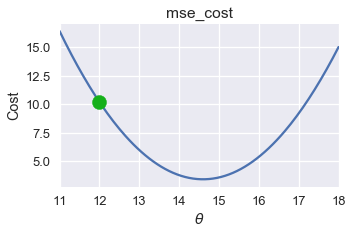

In [26]:
# HIDDEN
pts = np.array([12, 13, 15, 16, 17])
plot_cost(pts, (11, 18), mse_cost)
plot_theta_on_cost(pts, 12, mse_cost)

We'd like to choose a new value for $ \theta $ that decreases the cost. To do this, we look at the slope of the cost function at $ \theta = 12 $:

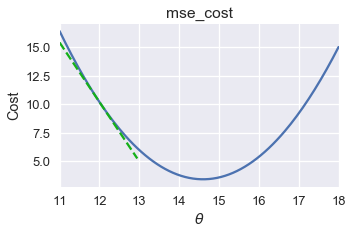

In [34]:
# HIDDEN
pts = np.array([12, 13, 15, 16, 17])
plot_cost(pts, (11, 18), mse_cost)
plot_tangent_on_cost(pts, 12, mse_cost)

The slope is negative, which means that increasing $ \theta $ will decrease the cost.

If $ \theta = 16.5 $ on the other hand, the slope of the cost function is positive:

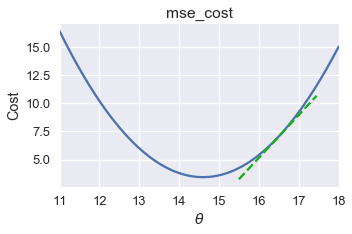

In [35]:
# HIDDEN
pts = np.array([12, 13, 15, 16, 17])
plot_cost(pts, (11, 18), mse_cost)
plot_tangent_on_cost(pts, 16.5, mse_cost)

When the slope is positive, decreasing $ \theta $ will decrease the cost.

The slope of the tangent line tells us which direction to move $ \theta $ in order to decrease the cost. If the slope is negative, we want $ \theta $ to move in the positive direction. If the slope is positive, $ \theta $ should move in the negative direction. Mathematically, we write:

$$
\theta_{t+1} = \theta_t - \frac{\partial}{\partial \theta} L(\theta, y)
$$

Where $ \theta_t $ is the current estimate and $ \theta_{t+1} $ is the next estimate.

For the MSE cost, we have:

$$
\begin{aligned}
L(\theta, y)
&= \frac{1}{n} \sum_{i = 1}^{n}(y_i - \theta)^2\\
\frac{\partial}{\partial \theta} L(\theta, y)
&= \frac{1}{n} \sum_{i = 1}^{n} -2(y_i - \theta) \\
&= -\frac{2}{n} \sum_{i = 1}^{n} (y_i - \theta) \\
\end{aligned}
$$

When $ \theta_t = 12 $, we can compute $ -\frac{2}{n} \sum_{i = 1}^{n} (y_i - \theta) = -5.2 $. Thus, $ \theta_{t+1} = 12 - (-5.2) = 17.2 $.

We've plotted the old value of $ \theta $ as a green outlined circle and the new value as a filled in circle on the cost curve below.

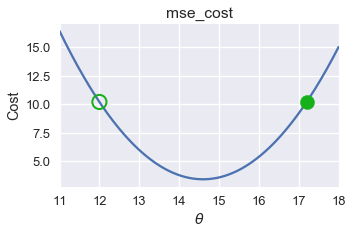

In [46]:
# HIDDEN
pts = np.array([12, 13, 15, 16, 17])
plot_cost(pts, (11, 18), mse_cost)
plot_theta_on_cost(pts, 12, mse_cost, c='none',
                   edgecolor=sns.xkcd_rgb['green'], linewidth=2)
plot_theta_on_cost(pts, 17.2, mse_cost)

Although $ \theta $ went in the right direction, it ended up as far away from the minimum as it started. We can remedy this by multiplying the slope by a small constant before subtracting it from $ \theta $. Our final update formula is:

$$
\theta_{t+1} = \theta_t - \alpha \cdot \frac{\partial}{\partial \theta} L(\theta, y)
$$

Where $ \alpha $ is a small constant. For example, if we set $ \alpha = 0.3 $ this is the new $ \theta_{t+1} $:

In [66]:
# HIDDEN
def plot_one_gd_iter(y_vals, theta, cost_fn, grad_cost, alpha=0.3):
    new_theta = theta - alpha * grad_cost(theta, y_vals)
    plot_cost(pts, (11, 18), cost_fn)
    plot_theta_on_cost(pts, theta, cost_fn, c='none',
                       edgecolor=sns.xkcd_rgb['green'], linewidth=2)
    plot_theta_on_cost(pts, new_theta, cost_fn)
    print(f'old theta: {theta}')
    print(f'new theta: {new_theta}')

old theta: 12
new theta: 13.56


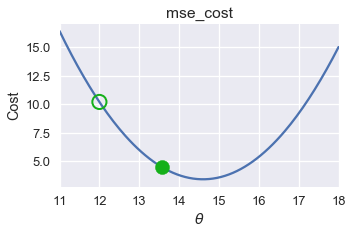

In [61]:
# HIDDEN
plot_one_gd_iter(pts, 12, mse_cost, grad_mse_cost)

Here are the $ \theta $ values for successive iterations of this process. Notice that $ \theta $ changes more slowly as it gets closer to the minimum cost because the slope is also smaller.

old theta: 13.56
new theta: 14.184000000000001


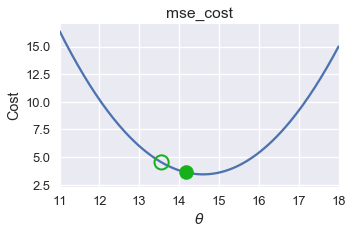

In [62]:
# HIDDEN
plot_one_gd_iter(pts, 13.56, mse_cost, grad_mse_cost)

old theta: 14.18
new theta: 14.432


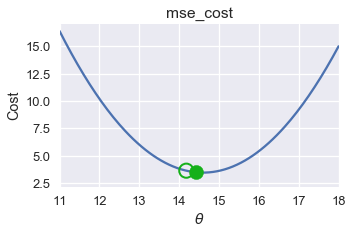

In [63]:
# HIDDEN
plot_one_gd_iter(pts, 14.18, mse_cost, grad_mse_cost)

old theta: 14.432
new theta: 14.5328


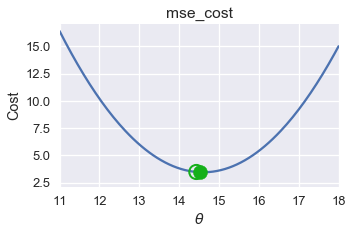

In [65]:
# HIDDEN
plot_one_gd_iter(pts, 14.432, mse_cost, grad_mse_cost)

### Gradient Descent Analysis

We now have the full algorithm for gradient descent:

1. Choose a starting value of $ \theta $ (0 is a common choice).
2. Compute $ \theta - \alpha \cdot \frac{\partial}{\partial \theta} L(\theta, y) $ and store this as the new value of $ \theta $.
3. Repeat until $ \theta $ doesn't change between iterations.

You will more commonly see the gradient $ \nabla_\theta $ in place of the partial derivative $ \frac{\partial}{\partial \theta} $. The two notations are essentially equivalent, but since the gradient notation is more common we will use it in the gradient update formula from now on:

$$
\theta_{t+1} = \theta_t - \alpha \cdot \nabla_\theta L(\theta, y)
$$

To review notation:

- $ \theta_t $ is the current choice of $ \theta $.
- $ \theta_{t+1} $ is the next choice of $ \theta $.
- $ \alpha $ is called the learning rate, usually set to a small constant. Sometimes it is useful to start with a larger $ \alpha $ and decrease it over time. If $ \alpha $ changes between iterations, we use the variable $ \alpha_t $ to mark that $ \alpha $ varies over time $ t $.
- $ \nabla_\theta L(\theta, y) $ is the partial derivative / gradient of the cost function at $ \theta $.

You can now see the importance of choosing a differentiable cost function: $ \nabla_\theta L(\theta, y) $ is a crucial part of the gradient descent algorithm. (While it is possible to estimate the gradient by computing the difference in cost for two slightly different values of $ \theta $ and dividing by the distance between $ \theta $ values, this typically increases the runtime of gradient descent so significantly that it becomes impractical to use.)

The gradient algorithm is simple yet powerful since we can use it for many types of models and many types of cost functions. It is the computational tool of choice for fitting many important models, including linear regression on large datasets and neural networks.

### Defining the `minimize` Function

Now we return to our original task: defining the `minimize` function. We will have to change our function signature slightly since we now need to compute the gradient of the cost function. 

In [84]:
def minimize(cost_fn, grad_cost_fn, dataset, alpha=0.2, progress=True):
    '''
    Uses gradient descent to minimize cost_fn. Returns the minimizing value of
    theta once theta changes less than 0.001 between iterations.
    '''
    theta = 0
    while True:
        if progress:
            print(f'theta: {theta:.2f} | cost: {cost_fn(theta, dataset):.2f}')
        gradient = grad_cost_fn(theta, dataset)
        new_theta = theta - alpha * gradient
        
        if abs(new_theta - theta) < 0.001:
            return new_theta
        
        theta = new_theta

Then we can define functions to compute our MSE cost and its gradient:

In [77]:
def mse_cost(theta, y_vals):
    return np.mean((y_vals - theta) ** 2)

def grad_mse_cost(theta, y_vals):
    return -2 * np.mean(y_vals - theta)

Finally, we can use the `minimize` function to compute the minimizing value of $ \theta $ for $ y = [ 12, 13, 15, 16, 17 ] $.

In [78]:
%%time
theta = minimize(mse_cost, grad_mse_cost, np.array([12, 13, 15, 16, 17]))
print(f'Minimizing theta: {theta}')
print()

theta: 0.00 | cost: 216.60
theta: 5.84 | cost: 80.18
theta: 9.34 | cost: 31.07
theta: 11.45 | cost: 13.39
theta: 12.71 | cost: 7.02
theta: 13.46 | cost: 4.73
theta: 13.92 | cost: 3.90
theta: 14.19 | cost: 3.61
theta: 14.35 | cost: 3.50
theta: 14.45 | cost: 3.46
theta: 14.51 | cost: 3.45
theta: 14.55 | cost: 3.44
theta: 14.57 | cost: 3.44
theta: 14.58 | cost: 3.44
theta: 14.59 | cost: 3.44
theta: 14.59 | cost: 3.44
theta: 14.60 | cost: 3.44
theta: 14.60 | cost: 3.44
Minimizing theta: 14.59851722463264

CPU times: user 2.6 ms, sys: 1.6 ms, total: 4.2 ms
Wall time: 3.02 ms


We can see that gradient quickly finds the same solution as the analytic method:

In [75]:
np.mean([12, 13, 15, 16, 17])

14.6

### Minimizing the Huber cost

Now, we can apply gradient descent to minimize the Huber cost on our dataset of tip percentages.

The Huber cost is:

$$
L_\delta(\theta, y) = \frac{1}{n} \sum_{i=1}^n \begin{cases}
    \frac{1}{2}(y_i - \theta)^2 &  | y_i - \theta | \le \delta \\
     \delta (|y_i - \theta| - \frac{1}{2} \delta ) & \text{otherwise}
\end{cases}
$$

The gradient of the Huber cost is:

$$
\nabla_{\theta} L_\delta(\theta, y) = \frac{1}{n} \sum_{i=1}^n \begin{cases}
    -(y_i - \theta) &  | y_i - \theta | \le \delta \\
    - \delta \cdot \text{sign} (y_i - \theta) & \text{otherwise}
\end{cases}
$$

(Note that in previous definitions of Huber cost we used the variable $ \alpha $ to denote the transition point. To avoid confusion with the $ \alpha $ used in gradient descent, we replace the transition point parameter of the Huber loss with $ \delta $.)

In [79]:
def huber_cost(theta, dataset, delta = 1):
    d = np.abs(theta - dataset)
    return np.mean(
        np.where(d <= delta,
                 (theta - dataset)**2 / 2.0,
                 delta * (d - delta / 2.0))
    )

def grad_huber_cost(theta, dataset, delta = 1):
    d = np.abs(theta - dataset)
    return np.mean(
        np.where(d <= delta,
                 -(dataset - theta),
                 -delta * np.sign(dataset - theta))
    )

Let's minimize the Huber cost on the tips dataset:

In [85]:
%%time
theta = minimize(huber_cost, grad_huber_cost, tips['pcttip'], progress=False)
print(f'Minimizing theta: {theta}')
print()

Minimizing theta: 15.506849531471964

CPU times: user 207 ms, sys: 6.9 ms, total: 213 ms
Wall time: 258 ms


### Summary

Gradient descent gives us a generic way to minimize a cost function when we cannot solve for the minimizing value of $ \theta $ analytically. As our models and cost functions increase in complexity, we will turn to gradient descent as our tool of choice to fit models.